## Key Performance Indicators

In [2]:
import sys
import os

%run ../data_preparation.ipynb
%store -r merged_df

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

Stored 'merged_df' (DataFrame)


### 1) Difference of doneChargingTime and disconnectTime in hours

-> Car is fully charged but still connected

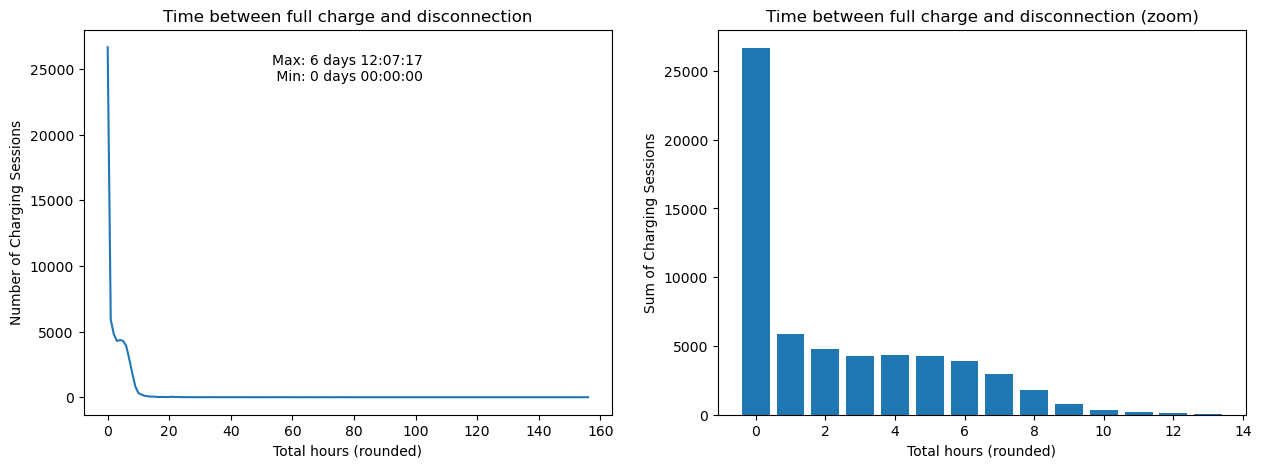

In [3]:
# Calculcate difference of disconnect and doneCharging time
merged_df['diff_connection'] = merged_df['disconnectTime'] - merged_df['doneChargingTime']
diff_connection = merged_df['diff_connection'].dropna().sort_values(ascending=True)

max = diff_connection.max()
min = diff_connection.min()

# Group by hour and count values
diff_connection_count = diff_connection.apply(lambda x : (x/np.timedelta64(1, 'h'))).astype(int).value_counts().sort_index()
diff_connection_count_zoom = diff_connection_count[diff_connection_count.values > 50]

## Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Time between full charge and disconnection
axs[0].plot(diff_connection_count.index, diff_connection_count.values)
axs[0].set_xlabel('Total hours (rounded)')
axs[0].set_ylabel('Number of Charging Sessions')
axs[0].set_title('Time between full charge and disconnection')
axs[0].text(0.5, 0.9, f'Max: {max}\n Min: {min}',  horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

# Time between full charge and disconnection with values over 50 hours only
axs[1].bar(diff_connection_count_zoom.index, diff_connection_count_zoom.values)
axs[1].set_xlabel('Total hours (rounded)')
axs[1].set_ylabel('Sum of Charging Sessions')
axs[1].set_title('Time between full charge and disconnection (zoom)')
plt.show()

### 2) Difference of kWhRequested and kWhDelivered

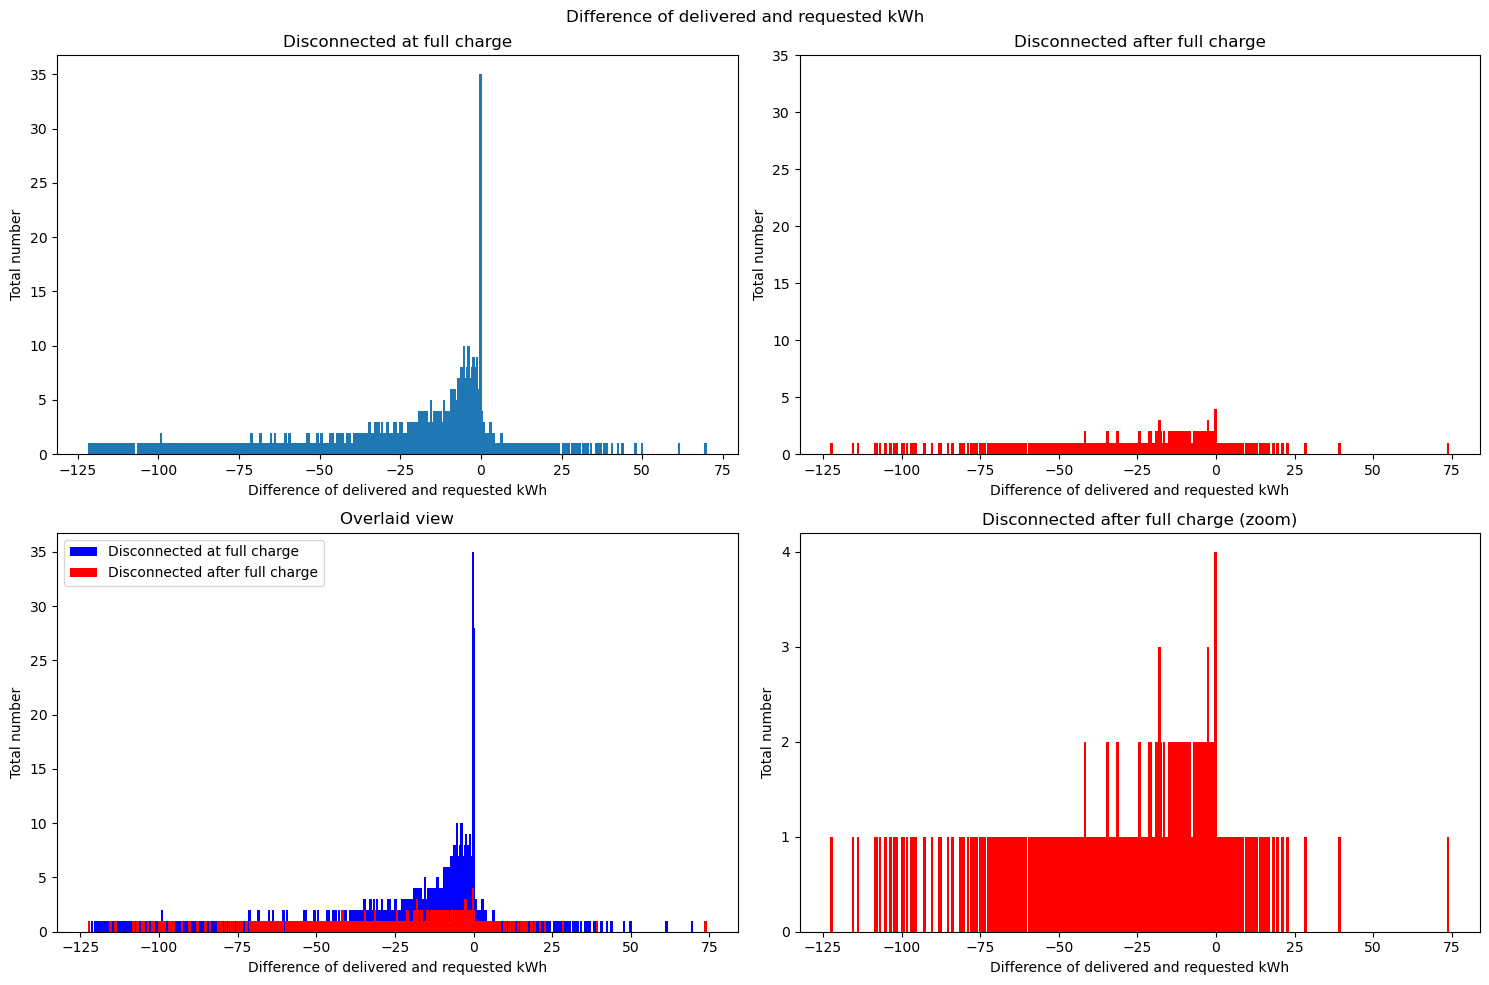

In [4]:
# Create new Dataframe with values where user inputs are provided
rows_with_userInputs = merged_df.loc[merged_df.modifiedAt.notna() & (merged_df.modifiedAt != '')].copy()

# Calculate difference of kWhDelivered and kWhRequested
rows_with_userInputs['kwhDiff'] = rows_with_userInputs['kWhDelivered'] - rows_with_userInputs['kWhRequested']

# Filter where difference of disconnect and doneCharging time equals zero
diff_connection_zero = rows_with_userInputs[rows_with_userInputs['diff_connection'] == pd.Timedelta(0)]
diff_connection_notZero = rows_with_userInputs[rows_with_userInputs['diff_connection'] > pd.Timedelta(0)]

diff_connection_zero_count = diff_connection_zero['kwhDiff'].value_counts().sort_index()
diff_connection_notZero_count = diff_connection_notZero['kwhDiff'].value_counts().sort_index()

## Plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle('Difference of delivered and requested kWh')

# Difference of disconnect and doneCharging time does not equal zero
axs[0, 0].bar(diff_connection_notZero_count.index, diff_connection_notZero_count.values)
axs[0, 0].set_xlabel('Difference of delivered and requested kWh')
axs[0, 0].set_ylabel('Total number')
axs[0, 0].set_title('Disconnected at full charge')

# Difference of disconnect and doneCharging time equals zero
axs[0, 1].bar(diff_connection_zero_count.index, diff_connection_zero_count.values, color='red')
axs[0, 1].set_xlabel('Difference of delivered and requested kWh')
axs[0, 1].set_ylabel('Total number')
axs[0, 1].set_title('Disconnected after full charge')
axs[0, 1].set_ylim(0, 35)

# Difference of disconnect and doneCharging time in different colors
axs[1, 0].bar(diff_connection_notZero_count.index, diff_connection_notZero_count.values, color='blue', label='Disconnected at full charge')
axs[1, 0].bar(diff_connection_zero_count.index, diff_connection_zero_count.values, color='red', label='Disconnected after full charge')
axs[1, 0].set_xlabel('Difference of delivered and requested kWh')
axs[1, 0].set_ylabel('Total number')
axs[1, 0].set_title('Overlaid view')
axs[1, 0].legend()

# Difference of disconnect and doneCharging time equals zero with a different scale
axs[1, 1].bar(diff_connection_zero_count.index, diff_connection_zero_count.values, color='red')
axs[1, 1].set_xlabel('Difference of delivered and requested kWh')
axs[1, 1].set_ylabel('Total number')
axs[1, 1].set_title('Disconnected after full charge (zoom)')
axs[1, 1].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### 3) Charging Speed

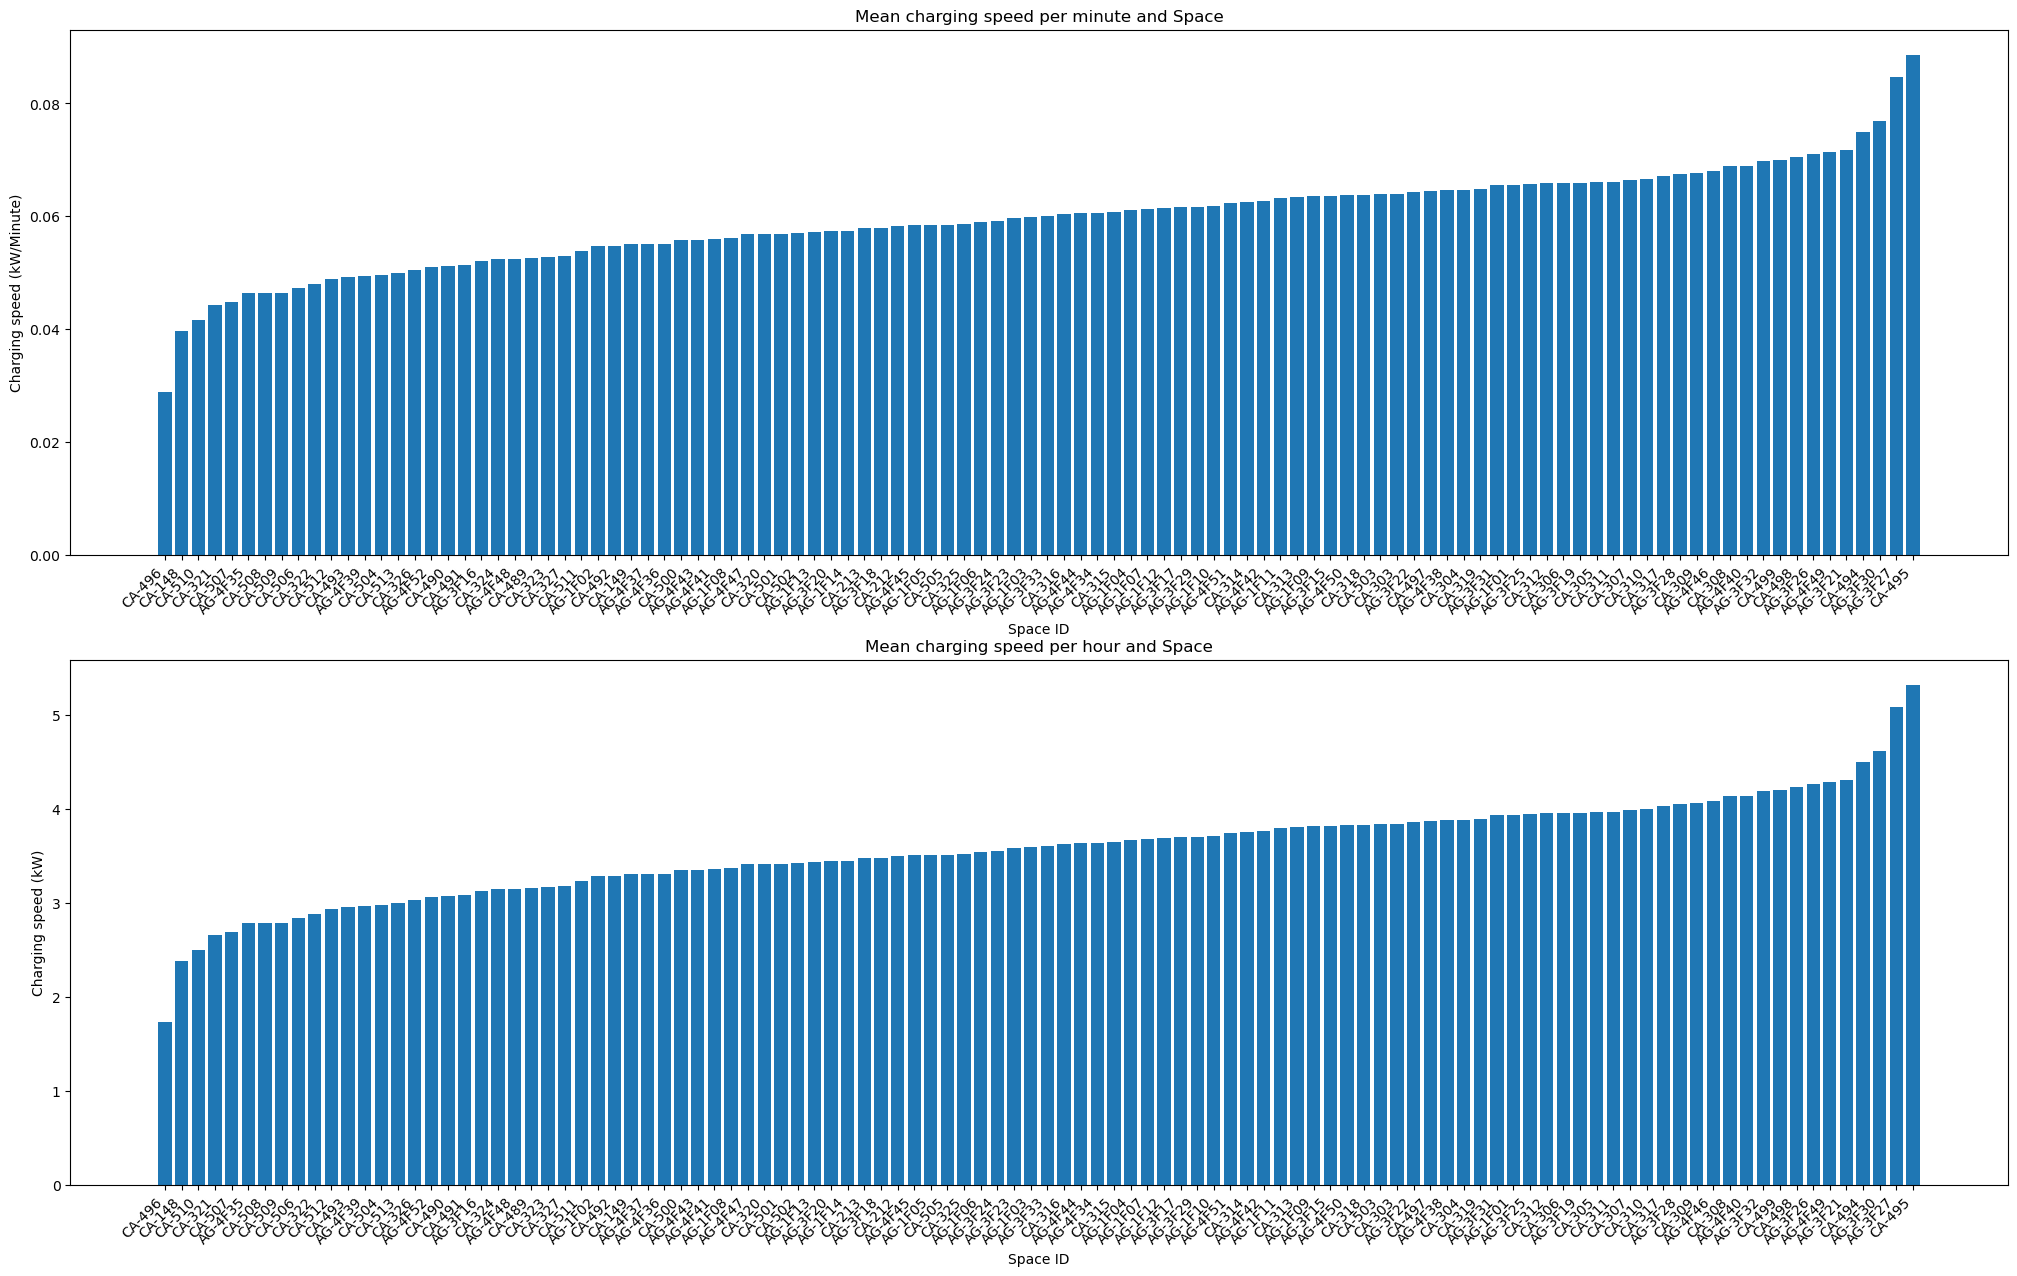

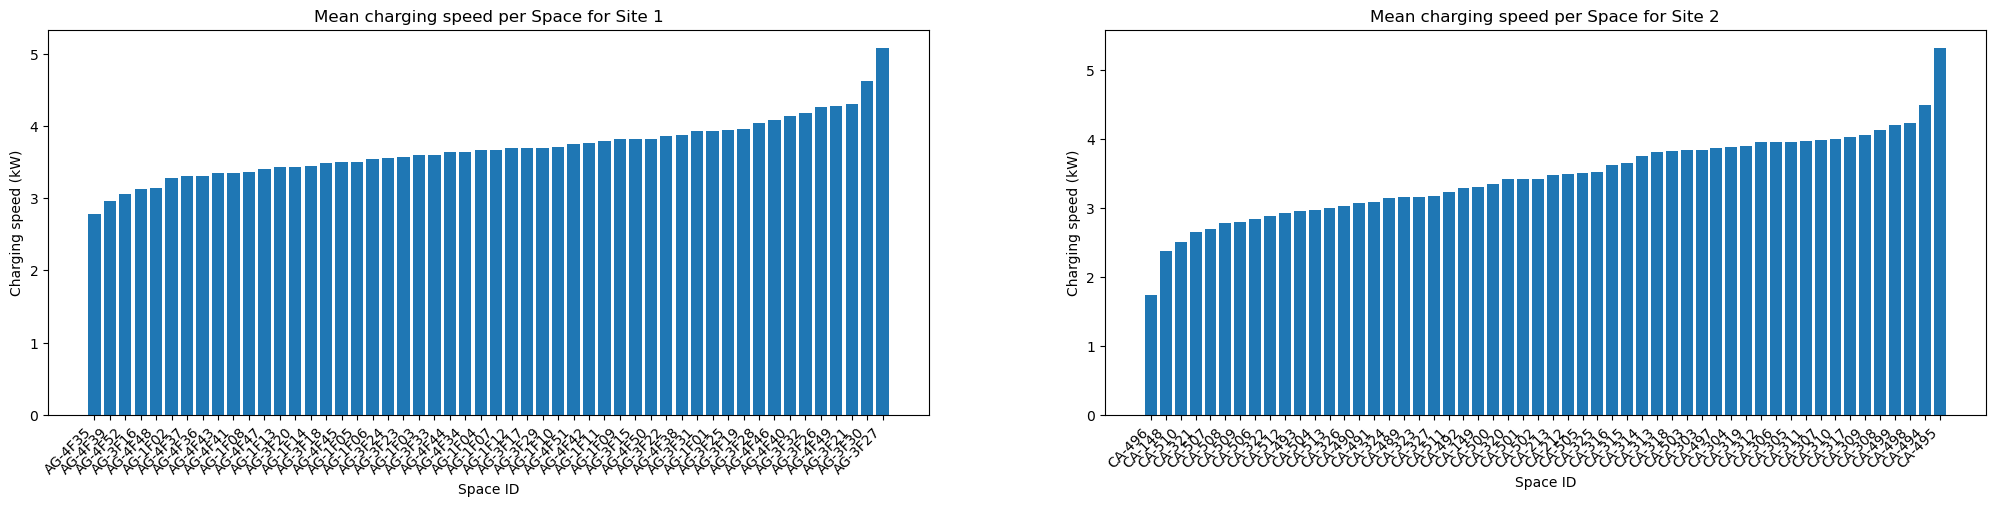

In [5]:
# Remove rows with no value for doneChargingTime
merged_df['doneChargingTime'] = merged_df['doneChargingTime'].replace('', pd.NaT)
rows_with_doneChargingTime = merged_df.dropna(subset=['doneChargingTime']).copy()

# Calculate difference of doneChargingTime and connectionTime -> total charging time
rows_with_doneChargingTime['chargingTime'] = (rows_with_doneChargingTime['doneChargingTime'] - rows_with_doneChargingTime['connectionTime']).dt.total_seconds()

# Remove rows with negative or zero charging time
rows_with_doneChargingTime = rows_with_doneChargingTime.loc[rows_with_doneChargingTime.chargingTime > 0]

# Filtern der Daten für jede Site
df_site1_with_doneChargingTim = rows_with_doneChargingTime.loc[rows_with_doneChargingTime.siteID == '1'].copy()
df_site2_with_doneChargingTim = rows_with_doneChargingTime.loc[rows_with_doneChargingTime.siteID == '2'].copy()

# Calculate charging speed per minute and hour
rows_with_doneChargingTime['chargingSpeed(kW/Minute)'] = rows_with_doneChargingTime['kWhDelivered']  / (rows_with_doneChargingTime['chargingTime'] / 60 )
rows_with_doneChargingTime['chargingSpeed(kW)'] = rows_with_doneChargingTime['kWhDelivered']  / (rows_with_doneChargingTime['chargingTime'] / 3600 )
df_site1_with_doneChargingTim['chargingSpeed(kW)'] = df_site1_with_doneChargingTim['kWhDelivered']  / (df_site1_with_doneChargingTim['chargingTime'] / 3600 )
df_site2_with_doneChargingTim['chargingSpeed(kW)'] = df_site2_with_doneChargingTim['kWhDelivered']  / (df_site2_with_doneChargingTim['chargingTime'] / 3600 )

# Group by SpaceID and calculate mean charging time
grouped_chargingSpeed_mean_min = rows_with_doneChargingTime.groupby('spaceID')['chargingSpeed(kW/Minute)'].mean().sort_values()
grouped_chargingSpeed_mean_hour = rows_with_doneChargingTime.groupby('spaceID')['chargingSpeed(kW)'].mean().sort_values()
grouped_chargingSpeed_mean_site1 = df_site1_with_doneChargingTim.groupby('spaceID')['chargingSpeed(kW)'].mean().sort_values()
grouped_chargingSpeed_mean_site2 = df_site2_with_doneChargingTim.groupby('spaceID')['chargingSpeed(kW)'].mean().sort_values()

## Plot
fig, axs = plt.subplots(2, 1, figsize=(25, 15))

# Mean charging speed per minute and space
axs[0].bar(grouped_chargingSpeed_mean_min.index, grouped_chargingSpeed_mean_min.values)
axs[0].set_xlabel('Space ID')
axs[0].set_ylabel('Charging speed (kW/Minute)')
axs[0].set_title('Mean charging speed per minute and Space')
axs[0].set_xticks(grouped_chargingSpeed_mean_min.index)
axs[0].set_xticklabels(grouped_chargingSpeed_mean_min.index, rotation=45, ha='right') 

# Mean charging speed per hour and space
axs[1].bar(grouped_chargingSpeed_mean_hour.index, grouped_chargingSpeed_mean_hour.values)
axs[1].set_xlabel('Space ID')
axs[1].set_ylabel('Charging speed (kW)')
axs[1].set_title('Mean charging speed per hour and Space')
axs[1].set_xticks(grouped_chargingSpeed_mean_hour.index)
axs[1].set_xticklabels(grouped_chargingSpeed_mean_hour.index, rotation=45, ha='right') 

## Plot per site
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

# Mean charging speed per space for Site 1
axs[0].bar(grouped_chargingSpeed_mean_site1.index, grouped_chargingSpeed_mean_site1.values)
axs[0].set_xlabel('Space ID')
axs[0].set_ylabel('Charging speed (kW)')
axs[0].set_title('Mean charging speed per Space for Site 1')
axs[0].set_xticks(grouped_chargingSpeed_mean_site1.index)
axs[0].set_xticklabels(grouped_chargingSpeed_mean_site1.index, rotation=45, ha='right') 

# Mean charging speed per space for Site 2
axs[1].bar(grouped_chargingSpeed_mean_site2.index, grouped_chargingSpeed_mean_site2.values)
axs[1].set_xlabel('Space ID')
axs[1].set_ylabel('Charging speed (kW)')
axs[1].set_title('Mean charging speed per Space for Site 2')
axs[1].set_xticks(grouped_chargingSpeed_mean_site2.index)
axs[1].set_xticklabels(grouped_chargingSpeed_mean_site2.index, rotation=45, ha='right') 

plt.show()

### 4) Registered and non-registered users

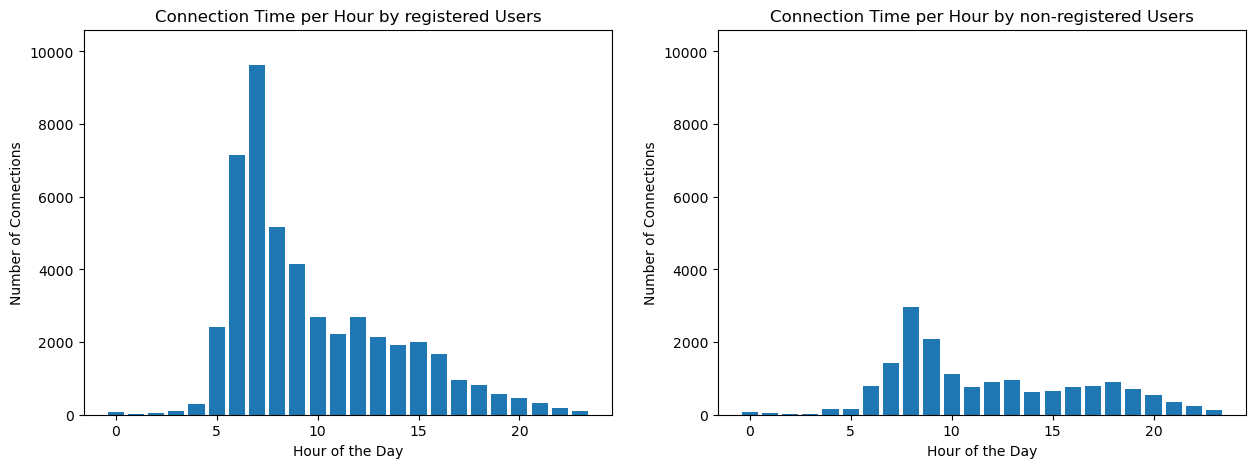

In [6]:
# Create new Dataframes for registered and non-registered users
rows_with_userId = merged_df.loc[merged_df.userID != 'nan'].copy()
rows_without_userId = merged_df.loc[merged_df.userID == 'nan'].copy()

# Calculate number of connected registered and non-registered users each hour
connection_counts_userId = rows_with_userId['connectionTime'].dt.hour.value_counts().sort_index()
connection_counts_noUserId = rows_without_userId['connectionTime'].dt.hour.value_counts().sort_index()

## Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
maxY = connection_counts_userId.values.max()+(connection_counts_userId.values.max()/10)

# Connection Time per Hour by registered Users
axs[0].bar(connection_counts_userId.index, connection_counts_userId.values)
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Number of Connections')
axs[0].set_title('Connection Time per Hour by registered Users')
axs[0].set_ylim(0, maxY)

# Connection Time per Hour by non-registered Users
axs[1].bar(connection_counts_noUserId.index, connection_counts_noUserId.values)
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Number of Connections')
axs[1].set_title('Connection Time per Hour by non-registered Users')
axs[1].set_ylim(0, maxY)

plt.show()